Import modules and data

In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import datetime

%matplotlib inline
#%matplotlib ipympl
%config InlineBackend.figure_format = 'retina'

from sklearn import preprocessing

# About the data


Trip History Data from https://capitalbikeshare.com/system-data

Quarterly Capital Bikeshare trip data. The data includes:

    Duration – Duration of trip
    Start Date – Includes start date and time
    End Date – Includes end date and time
    Start Station – Includes starting station name and number
    End Station – Includes ending station name and number
    Bike Number – Includes ID number of bike used for the trip [not available in most recent data]
    Member Type – Indicates whether user was a "registered" member (Annual Member, 30-Day Member or Day Key Member) or a "casual" rider (Single Trip, 24-Hour Pass, 3-Day Pass or 5-Day Pass)

This data has been processed to remove trips that are taken by staff as they service and inspect the system, trips that are taken to/from any of our “test” stations at our warehouses and any trips lasting less than 60 seconds (potentially false starts or users trying to re-dock a bike to ensure it's secure).
NOTE: The 3-Day Membership replaced the 5-Day Membership in Fall 2011

Beware inclusion of dockless bikes and e-scooters after a certain point.


In [149]:
df_2023_04 = pd.read_csv('202304-capitalbikeshare-tripdata.csv')

# Project Goals

Develop KPIs and make predictions

Idea: use demographic information to cross-reference with journey start/end points


# First steps

check shape and column names

In [150]:
display(df_2023_04.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389243 entries, 0 to 389242
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             389243 non-null  object 
 1   rideable_type       389243 non-null  object 
 2   started_at          389243 non-null  object 
 3   ended_at            389243 non-null  object 
 4   start_station_name  360858 non-null  object 
 5   start_station_id    360858 non-null  float64
 6   end_station_name    358630 non-null  object 
 7   end_station_id      358630 non-null  float64
 8   start_lat           389243 non-null  float64
 9   start_lng           389243 non-null  float64
 10  end_lat             388555 non-null  float64
 11  end_lng             388555 non-null  float64
 12  member_casual       389243 non-null  object 
dtypes: float64(6), object(7)
memory usage: 38.6+ MB


None

In [151]:
display(df_2023_04.head())

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,7D89911108C4305F,classic_bike,2023-04-15 12:51:45,2023-04-15 12:57:14,16th & Harvard St NW,31135.0,Lamont & Mt Pleasant NW,31107.0,38.926102,-77.036650,38.931900,-77.038800,member
1,FF47021098DE06BD,electric_bike,2023-04-11 18:21:35,2023-04-11 18:37:47,Rosedale Rec Center,31658.0,6th St & Indiana Ave NW,31264.0,38.897897,-76.979721,38.894573,-77.019940,member
2,BB41905DB8DE1CC7,classic_bike,2023-04-16 18:09:23,2023-04-16 18:26:10,2nd St & Seaton Pl NE,31522.0,15th & W St NW,31125.0,38.914751,-77.003560,38.919018,-77.034449,member
3,0B1CB1A1E2380DD9,electric_bike,2023-04-29 17:13:36,2023-04-29 17:17:37,2nd St & Seaton Pl NE,31522.0,MBT & Bryant St NE,31531.0,38.914697,-77.003593,38.922404,-76.996023,member
4,D321DE32CAFDDD51,classic_bike,2023-04-29 17:53:46,2023-04-29 18:02:10,23rd & E St NW,31260.0,15th & M St NW,31298.0,38.896104,-77.049882,38.905424,-77.034674,member


In [152]:
#set ride_id as index
#TODO: find out if this is a bad idea
#df_2023_04.set_index('ride_id')

check for missing values

In [153]:
display("Empty fields:",df_2023_04.isnull().sum(), df_2023_04.isna().sum())

'Empty fields:'

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    28385
start_station_id      28385
end_station_name      30613
end_station_id        30613
start_lat                 0
start_lng                 0
end_lat                 688
end_lng                 688
member_casual             0
dtype: int64

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    28385
start_station_id      28385
end_station_name      30613
end_station_id        30613
start_lat                 0
start_lng                 0
end_lat                 688
end_lng                 688
member_casual             0
dtype: int64

check for duplicated values

In [154]:
display('Counts of duplicated items:', df_2023_04.drop('ride_id', axis = 1).duplicated().value_counts()) #why do i have to trop ride_id if it is the index? 
# also why did i get loads more results first time?

'Counts of duplicated items:'

False    389225
True         18
dtype: int64

There are 581 (or 18 ?? got two different results) duplicate records, once the unique ride ID is ignored.

In [155]:
df_2023_04[df_2023_04.drop('ride_id', axis = 1).duplicated(keep=False)].sort_values(by=['started_at'])

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
229411,EC87487562C28E93,classic_bike,2023-04-02 21:31:44,2023-04-02 21:54:18,USDA / 12th & C St SW,31217.0,20th & E St NW,31204.0,38.886277,-77.028242,38.896300,-77.045000,casual
229409,1845562C28A56D03,classic_bike,2023-04-02 21:31:44,2023-04-02 21:54:18,USDA / 12th & C St SW,31217.0,20th & E St NW,31204.0,38.886277,-77.028242,38.896300,-77.045000,casual
274578,02BAEE25CE7889D9,classic_bike,2023-04-07 12:37:35,2023-04-07 13:21:06,19th St & Constitution Ave NW,31235.0,1st & D St SE,31643.0,38.892212,-77.043074,38.884916,-77.005965,casual
274552,82BFA6942C47AC08,classic_bike,2023-04-07 12:37:35,2023-04-07 13:21:06,19th St & Constitution Ave NW,31235.0,1st & D St SE,31643.0,38.892212,-77.043074,38.884916,-77.005965,casual
185277,FD1FBFC11353FC0A,classic_bike,2023-04-09 13:53:40,2023-04-09 14:20:30,3000 Connecticut Ave NW / National Zoo,31307.0,1st & O St NW,31519.0,38.930282,-77.055599,38.908643,-77.012365,member
81569,08052F97EFABD88E,classic_bike,2023-04-09 13:53:40,2023-04-09 14:20:30,3000 Connecticut Ave NW / National Zoo,31307.0,1st & O St NW,31519.0,38.930282,-77.055599,38.908643,-77.012365,member
105108,9F691C5E28AF6256,classic_bike,2023-04-12 14:34:55,2023-04-12 15:18:48,Smithsonian-National Mall / Jefferson Dr & 12t...,31248.0,Henry Bacon Dr & Lincoln Memorial Circle NW,31289.0,38.888774,-77.028694,38.890539,-77.049383,casual
180957,DCEB1FEFC85ACBF0,classic_bike,2023-04-12 14:34:55,2023-04-12 15:18:48,Smithsonian-National Mall / Jefferson Dr & 12t...,31248.0,Henry Bacon Dr & Lincoln Memorial Circle NW,31289.0,38.888774,-77.028694,38.890539,-77.049383,casual
103669,BA2F8DE3F38F4CF2,classic_bike,2023-04-13 11:34:51,2023-04-13 12:13:33,Harvard St & Adams Mill Rd NW,31112.0,10th St & Constitution Ave NW,31219.0,38.927872,-77.043358,38.893028,-77.026013,member
116824,5DDB384604B22FF3,classic_bike,2023-04-13 11:34:51,2023-04-13 12:13:33,Harvard St & Adams Mill Rd NW,31112.0,10th St & Constitution Ave NW,31219.0,38.927872,-77.043358,38.893028,-77.026013,member


drop duplicates

In [156]:
#TODO

check and change data types

In [157]:
df_2023_04.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id      float64
end_station_name       object
end_station_id        float64
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [158]:
# cast 'started_at' and 'ended_at' columns to pandas 'datetime' object dtype https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
df_2023_04['started_at'] = pd.to_datetime(df_2023_04['started_at'])
df_2023_04['ended_at'] = pd.to_datetime(df_2023_04['ended_at'])

#cast rideable_type and member_casual to categorical
df_2023_04['rideable_type'] = pd.Categorical(df_2023_04['rideable_type'], ordered=False)
df_2023_04['member_casual'] = pd.Categorical(df_2023_04['member_casual'], ordered=False)

df_2023_04.dtypes

ride_id                       object
rideable_type               category
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id             float64
end_station_name              object
end_station_id               float64
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual               category
dtype: object

check how many unique values are in each variable

In [159]:
display(df_2023_04.nunique())

ride_id               389243
rideable_type              3
started_at            343635
ended_at              343939
start_station_name       728
start_station_id         727
end_station_name         730
end_station_id           729
start_lat              76943
start_lng              77423
end_lat                  908
end_lng                  920
member_casual              2
dtype: int64

Note: there are more ride IDs than unique times

# Histplot/univariate plots

Text(0.5, 0.98, 'Univariate plots April 2023')

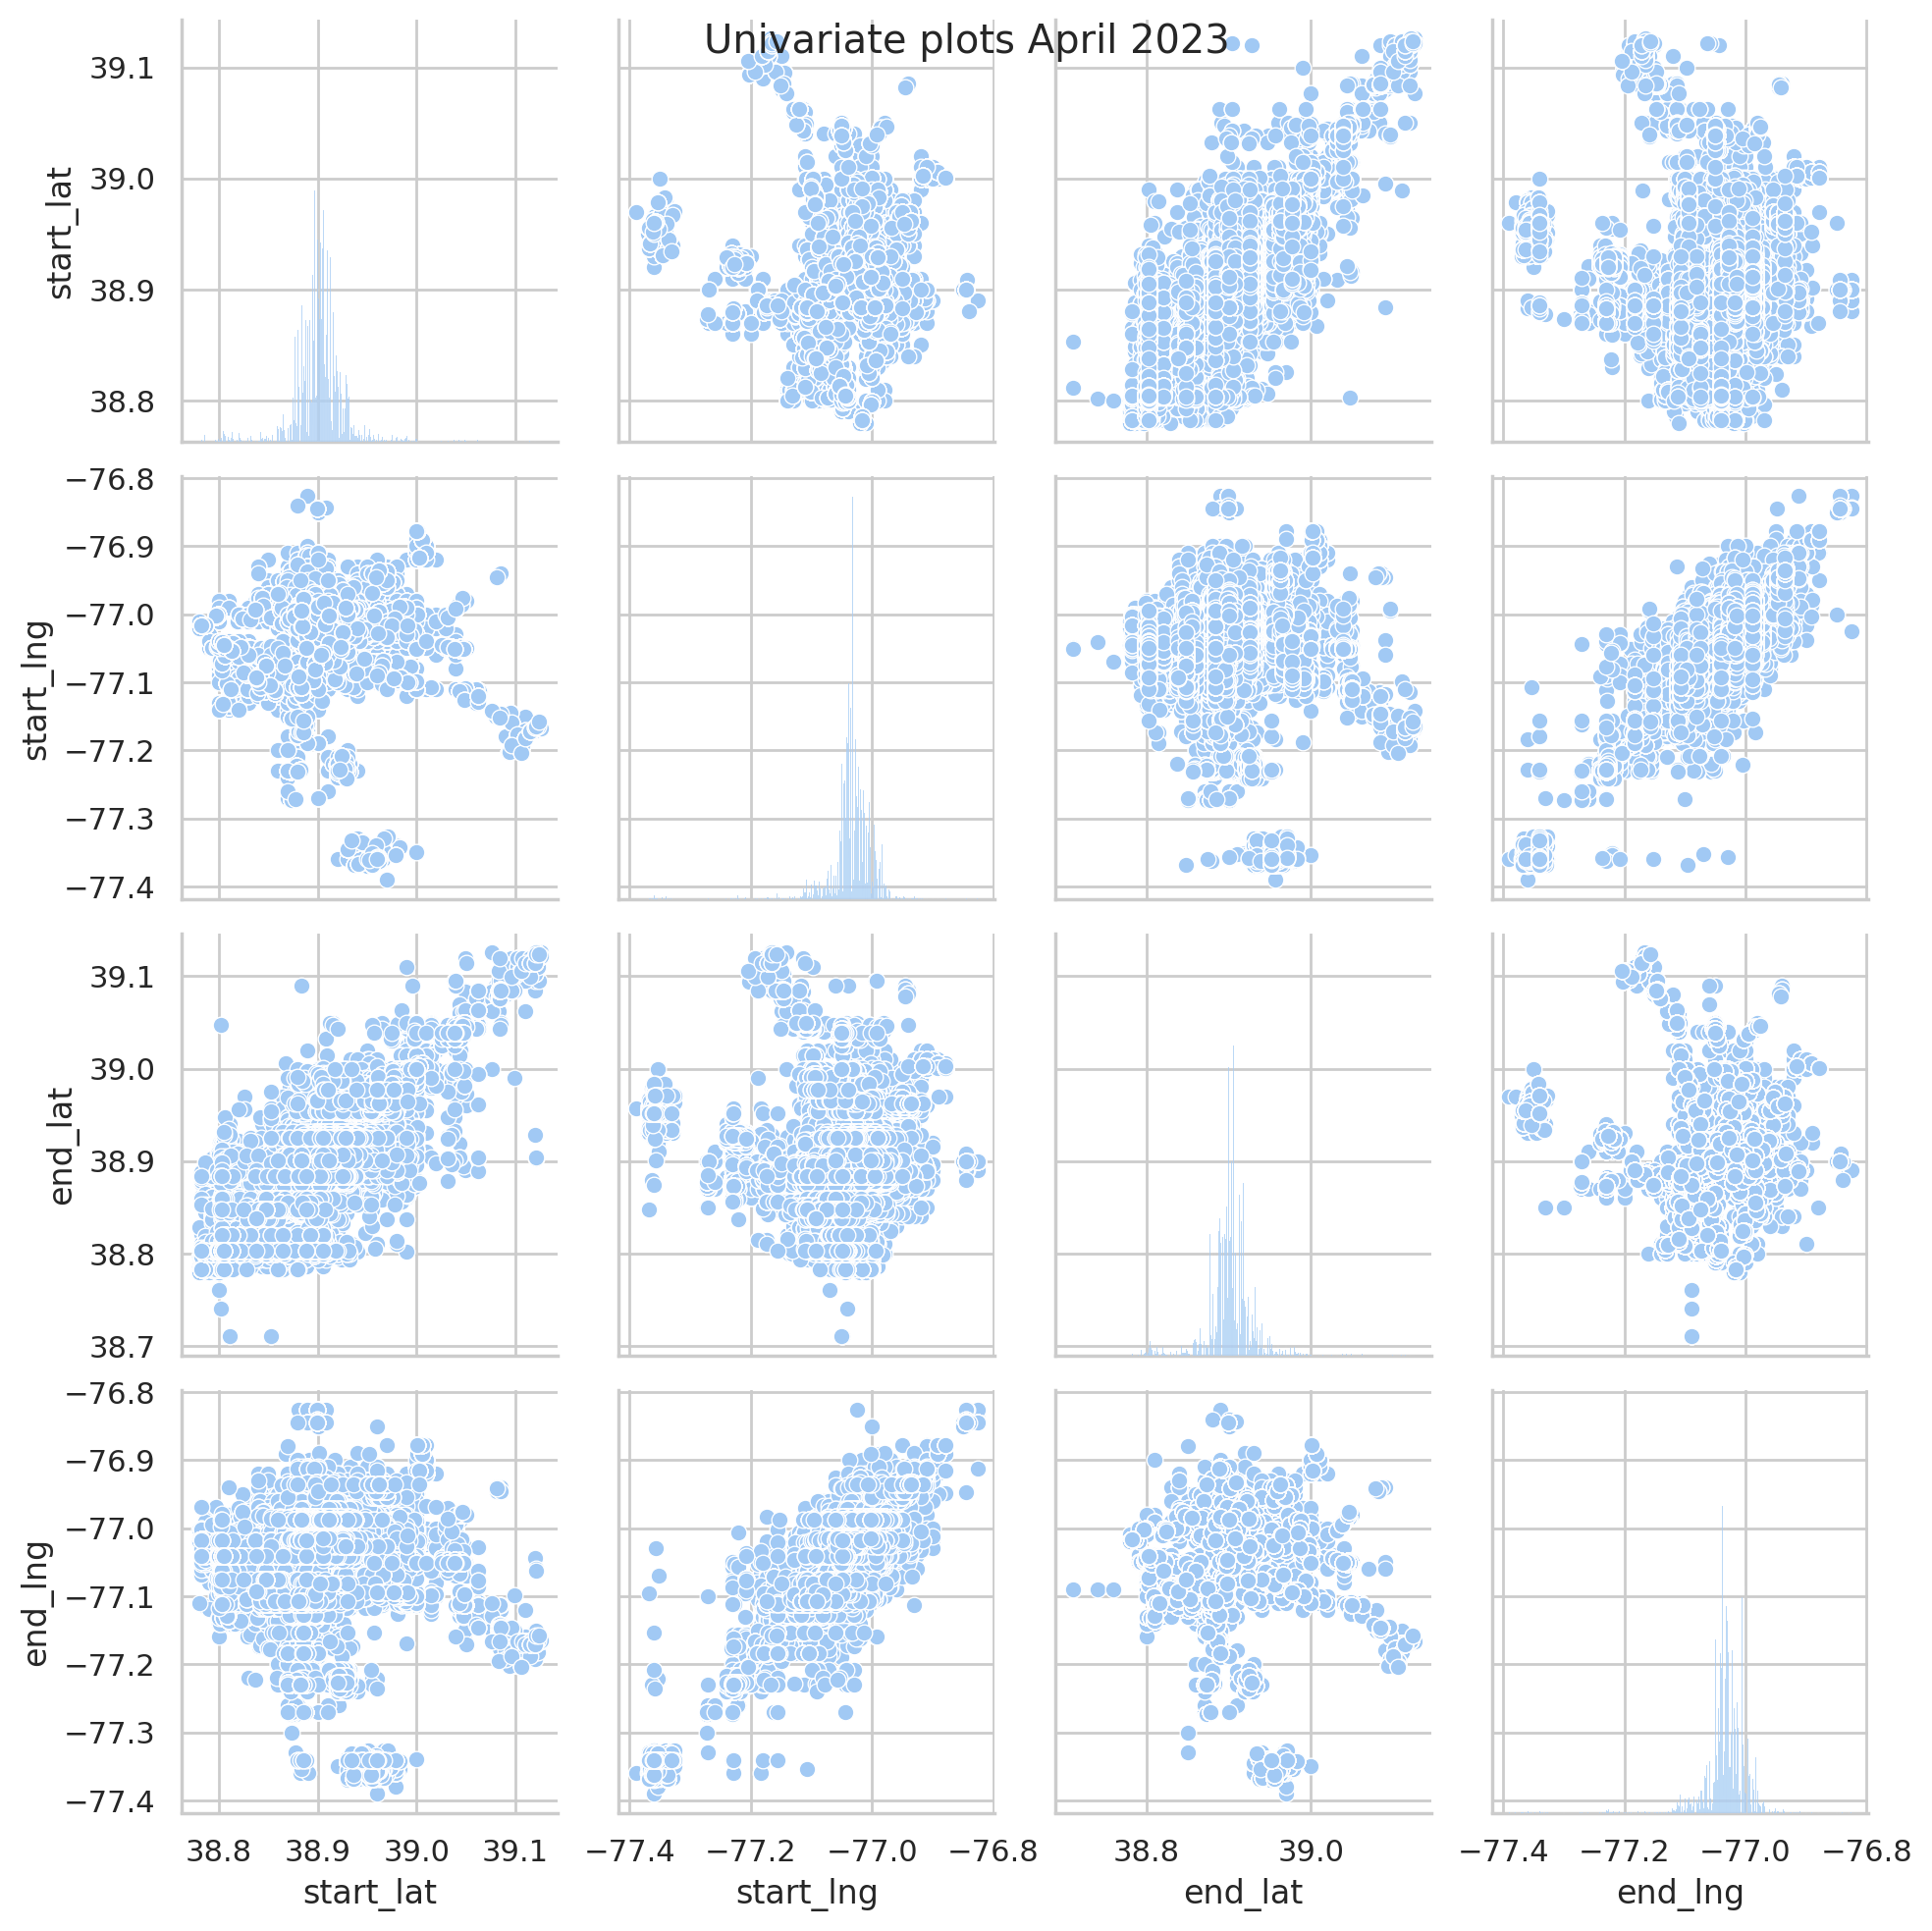

In [160]:
sns.set_theme(style="whitegrid", palette="pastel")

sns.pairplot(df_2023_04.drop(columns = ['start_station_id', 'end_station_id'], axis = 1))
plt.suptitle('Univariate plots April 2023')

# Find information about vehicles and journeys

Questions:
- what is the difference between classic and docked bike? and do scooters not appear on the list?
- how many journeys do not start from a docking station?

## What can the data tell us about the vehicles in use?

check unique vehicle types in this dataset and number of journeys using each

classic_bike     257729
electric_bike    113718
docked_bike       17796
Name: rideable_type, dtype: int64


<Axes: xlabel='rideable_type', ylabel='Count'>

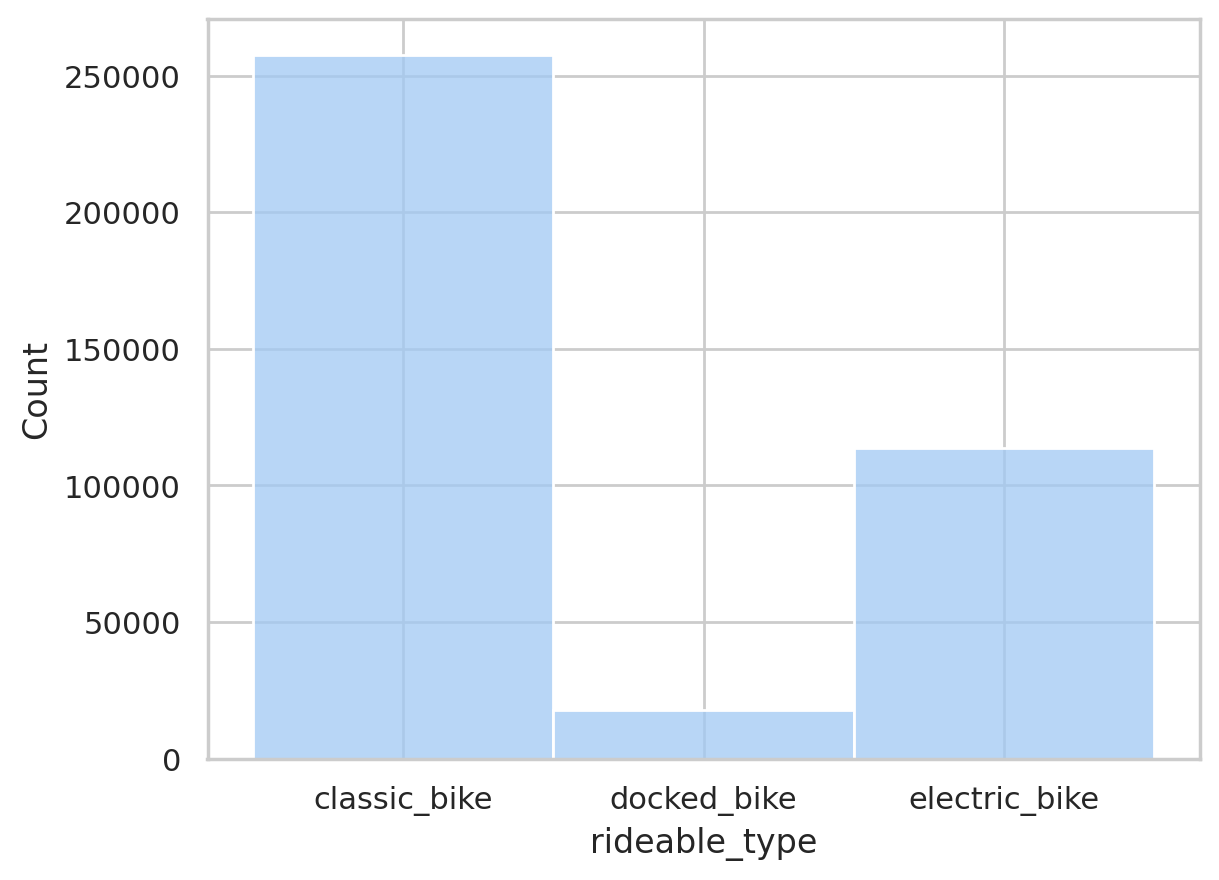

In [161]:
print(df_2023_04.rideable_type.value_counts())
sns.histplot(df_2023_04.rideable_type)

### Did the usage of the three vehicle types change over the month of April? 

make a line plot with three lines for daily counts of vehicle types - this could indicate that one type is being phased out, as new vehicles were introduced this year but it is not clear what label in the dataset represents them


<Axes: xlabel='started_at'>

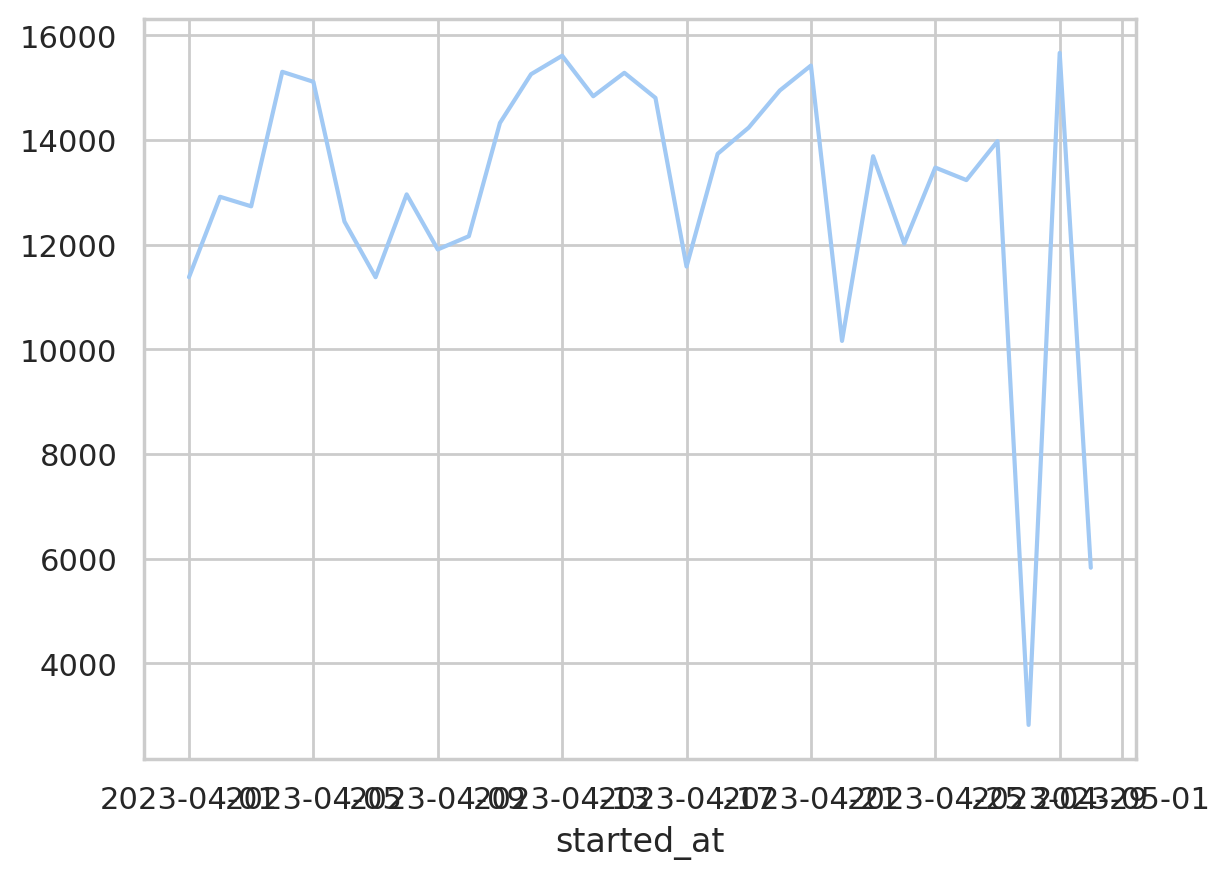

In [162]:
#first, plot all journeys' counts by date - begin with a series of counts grouped by date 
df_per_date = df_2023_04["started_at"].groupby(df_2023_04["started_at"].dt.date).count().plot()
df_per_date

In [163]:
# failed attempts at plotting each rideable type per day:

#df_date_r_t1 = df_2023_04.groupby(["rideable_type", df_2023_04["started_at"].dt.date]).count()
#df_date_r_t1 = df_date_r_t1.reset_index()

# df_per_date_r_t2 = df_2023_04["rideable_type"].groupby(df_2023_04["started_at"].dt.date).count()
# df_per_date_r_t2 = pd.DataFrame(df_per_date_r_t2).reset_index()
# df_per_date_r_t2

# double grouping does not work with any of the graphs I tried. it created a double index, so I needed to use .unstack() :

In [164]:
# plotting each rideable type per day:
#create a new df of item counts (of ride_id) grouped by both date and rideable type, 
#then unstack to remove the resulting mulitindex.
df_per_date_r_t = df_2023_04.groupby([(df_2023_04["started_at"].dt.date), "rideable_type"]).count().unstack().iloc[:, 0:3]
#display(df_per_date_r_t)

<Axes: title={'center': 'Usage of each rideable type per day (April 2023)'}, xlabel='started_at'>

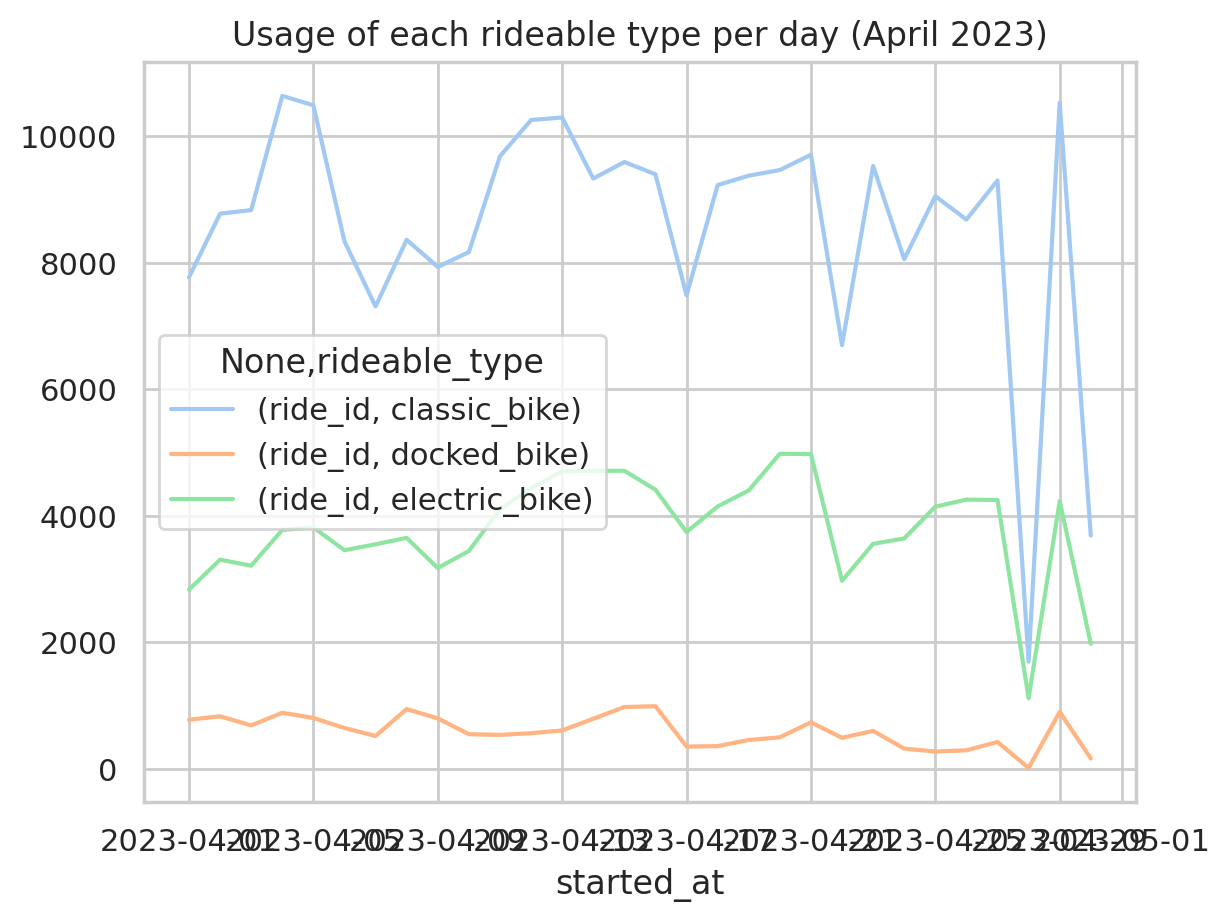

In [165]:
df_per_date_r_t.plot(title="Usage of each rideable type per day (April 2023)")
#TODO: formatting

Explore the journeys with no start or end station

In [166]:
#TODO
df_dockless = (df_2023_04[(df_2023_04.start_station_id.isnull()) | (df_2023_04.start_station_id.isnull())])
display(df_dockless)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
980,70760945F974BE13,electric_bike,2023-04-29 13:00:06,2023-04-29 13:16:51,NaN,NaN,Massachusetts Ave & Dupont Circle NW,31200.0,38.92,-77.08,38.910100,-77.044400,member
981,23DD817CF337A3B6,electric_bike,2023-04-01 15:07:25,2023-04-01 15:38:14,NaN,NaN,L'Enfant Plaza / 7th & C St SW,31218.0,38.89,-77.03,38.886266,-77.022241,casual
1082,51ADAF8C6B02CC65,electric_bike,2023-04-05 08:31:09,2023-04-05 08:31:36,NaN,NaN,NaN,NaN,38.90,-77.00,38.900000,-77.000000,member
1083,89B89D4C920EC9CE,electric_bike,2023-04-06 16:05:33,2023-04-06 16:09:04,NaN,NaN,NaN,NaN,38.90,-77.04,38.890000,-77.040000,member
1084,00BF8BBB0E14EB75,electric_bike,2023-04-06 11:28:40,2023-04-06 11:53:30,NaN,NaN,NaN,NaN,38.89,-77.01,38.900000,-77.040000,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
388975,D639BB93208B016D,electric_bike,2023-04-26 19:27:20,2023-04-26 19:36:48,NaN,NaN,Langston Blvd & N Scott St,31080.0,38.90,-77.11,38.897612,-77.080851,casual
388976,D4D816795F5DF441,electric_bike,2023-04-04 07:43:53,2023-04-04 07:47:02,NaN,NaN,4th & E St SW,31244.0,38.88,-77.02,38.884120,-77.017445,casual
388977,3E14179B29546BC1,electric_bike,2023-04-21 10:27:49,2023-04-21 12:19:39,NaN,NaN,Prince St & Union St,31041.0,38.80,-77.04,38.803124,-77.040363,casual
388978,B3DA95BE6FCE7652,electric_bike,2023-04-06 17:51:43,2023-04-06 18:07:28,NaN,NaN,S Troy St & 26th St S,31056.0,38.86,-77.05,38.847977,-77.075104,casual


<Axes: title={'center': 'Rideable type usage without dock per day (April 2023)'}, xlabel='started_at'>

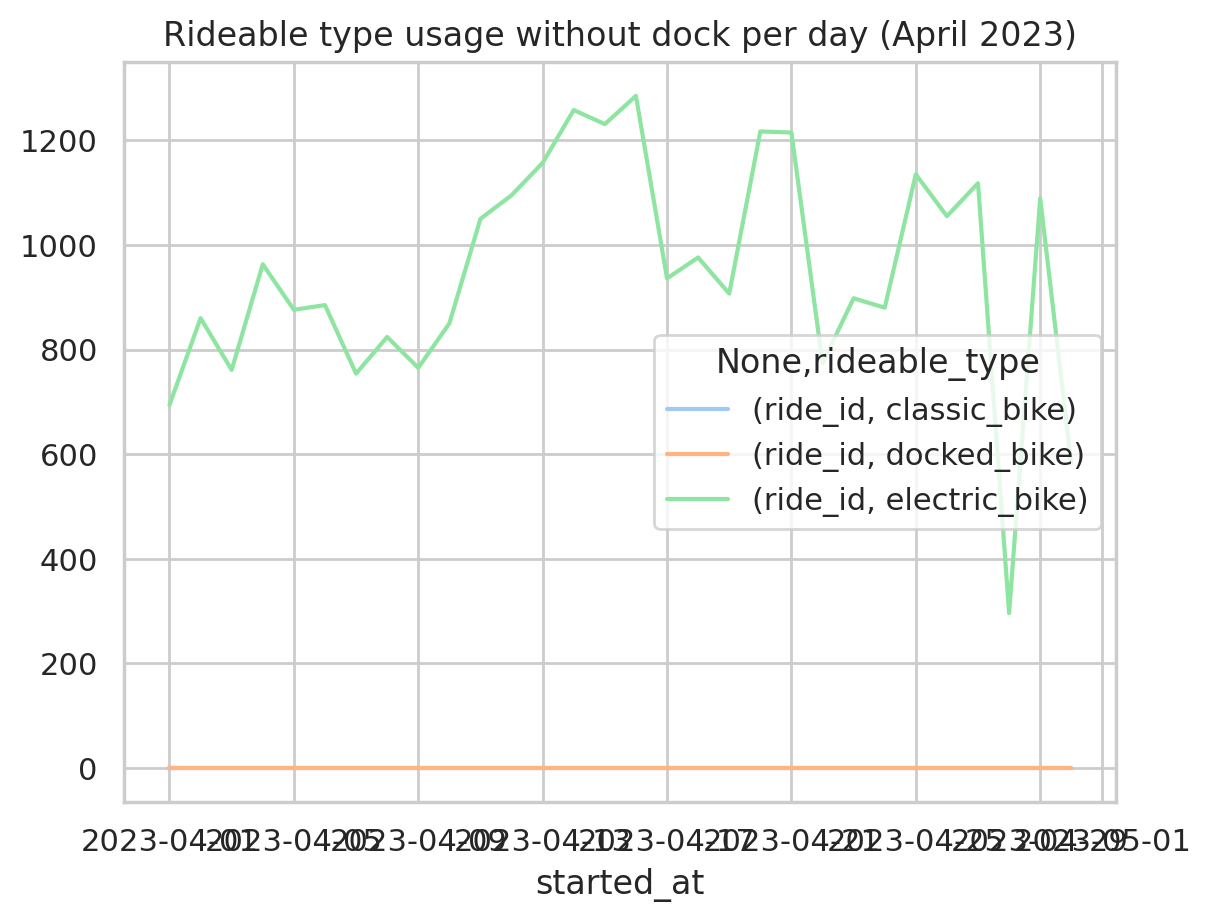

In [167]:
df_per_date_dockless_r_t = df_dockless.groupby([(df_2023_04["started_at"].dt.date), "rideable_type"]).count().unstack().iloc[:, 0:3]
df_per_date_dockless_r_t.plot(title="Rideable type usage without dock per day (April 2023)")

- it appears that only the electric bikes were used without a dock on both sides. Is it then only electric bikes that may be locked outside a dock for a fee?

Which hour-periods of the day did journeys start at (frequency)?

Text(0.5, 1.0, 'Hour-periods when journeys started (April 2023)')

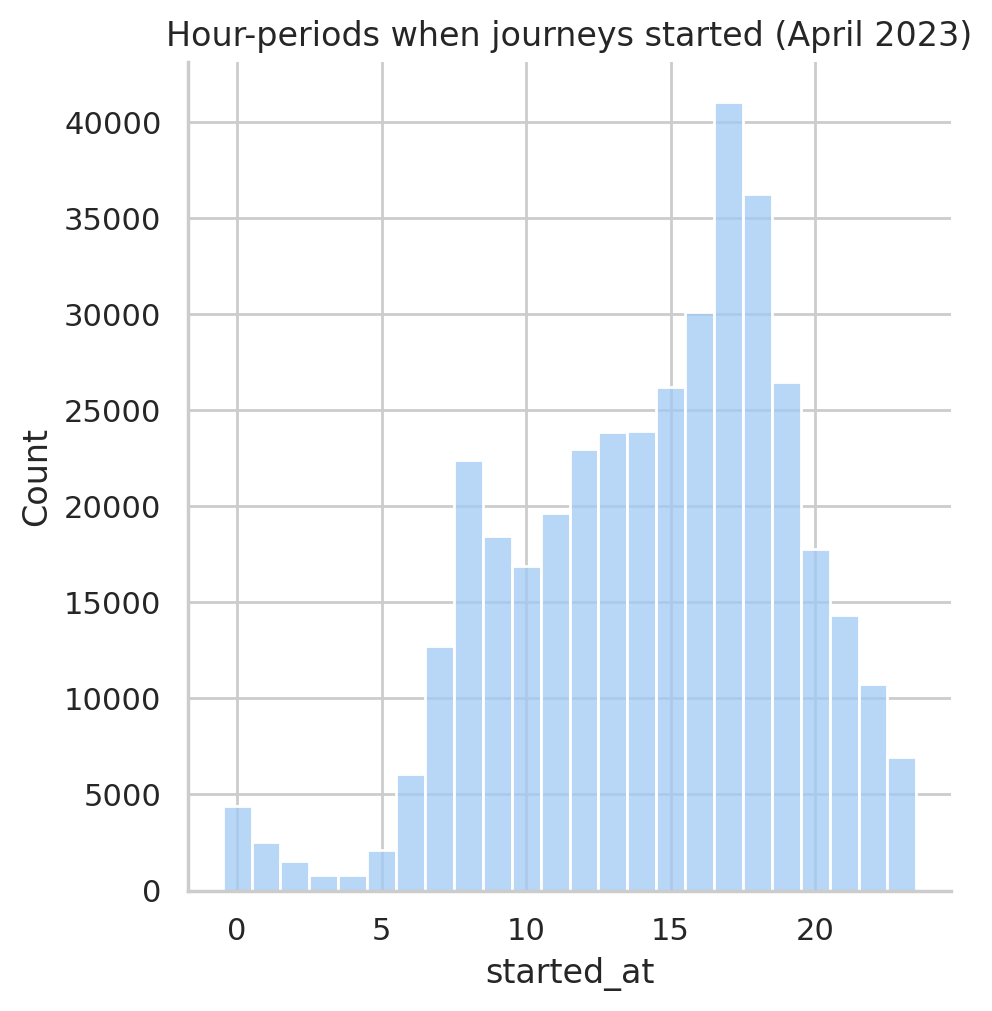

In [168]:
g_hour_dist = sns.displot(data=df_2023_04.started_at.dt.hour, discrete=True)
plt.title("Hour-periods when journeys started (April 2023)")


In [169]:
#TODO: plot on clock as radial histogram? http://qingkaikong.blogspot.com/2016/04/plot-histogram-on-clock.html

Resampling

In [170]:
#TODO: try out resample()

# Do registered riders ride further (net distance)?

In [171]:
# create a straight-line vector distance from the start and end coordinates 
#source for function: https://kanoki.org/2019/12/27/how-to-calculate-distance-in-python-and-pandas-using-scipy-spatial-and-distance-functions/#calculate-distance-between-origin-and-dest
def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

df_2023_04['distance'] = haversine_vectorize(df_2023_04['start_lng'],df_2023_04['start_lat'],df_2023_04['end_lng'], df_2023_04['end_lat'])

In [172]:
#show overview of net distances
display(df_2023_04.distance, "Max Distance:", df_2023_04.distance.max(), "Mean Distance:", df_2023_04.distance.mean())

0         0.670575
1         3.497933
2         2.712487
3         1.077837
4         1.674044
            ...   
389238    6.211805
389239    1.912751
389240    1.912751
389241    2.805129
389242    1.704084
Name: distance, Length: 389243, dtype: float64

'Max Distance:'

29.009908352858023

'Mean Distance:'

1.879360860625674

In [193]:
#TODO: the calculation here is probably wrong, it just appeared right for shorter journeys!
#add a new column for elapsed time using logical comparison of datetime objects
df_2023_04['elapsed'] = (df_2023_04.ended_at - df_2023_04.started_at)
df_2023_04.reset_index()
display(df_2023_04.sort_values('elapsed'))

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance,elapsed
11125,E55D603944B8FCD0,electric_bike,2023-04-01 13:10:57,2023-04-01 13:05:36,NaN,NaN,1st & D St SE,31643.0,38.880000,-77.010000,38.884916,-77.005965,member,0.648278,-1 days +23:54:39
273292,511BA3014B445EC9,electric_bike,2023-04-01 13:21:28,2023-04-01 13:16:39,NaN,NaN,1st & D St SE,31643.0,38.880000,-77.010000,38.884916,-77.005965,casual,0.648278,-1 days +23:55:11
225078,44AF0B55F8F746B6,electric_bike,2023-04-07 17:36:37,2023-04-07 17:31:54,NaN,NaN,Hamlin & 7th St NE,31514.0,38.930000,-77.000000,38.927497,-76.997194,member,0.369061,-1 days +23:55:17
23713,46530EFD3B36F5CE,electric_bike,2023-04-05 08:36:17,2023-04-05 08:31:39,NaN,NaN,Columbia Rd & Belmont St NW,31113.0,38.920000,-77.040000,38.920669,-77.043680,member,0.326734,-1 days +23:55:22
158268,26951567BEB18E0D,electric_bike,2023-04-25 14:46:40,2023-04-25 14:42:24,NaN,NaN,1st & Washington Hospital Center NW,31507.0,38.930000,-77.010000,38.928743,-77.012457,member,0.254215,-1 days +23:55:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278463,492F5E3810934F0B,docked_bike,2023-04-15 11:20:00,2023-04-30 14:55:42,Jefferson Dr & 14th St SW,31247.0,6035 Warehouse,32901.0,38.888553,-77.032427,38.963810,-77.010266,casual,8.579581,15 days 03:35:42
129337,26FD697DC683BFF3,docked_bike,2023-04-09 23:56:17,2023-04-27 04:56:48,Largo Town Center Metro,32401.0,NaN,NaN,38.899811,-76.844604,NaN,NaN,casual,NaN,17 days 05:00:31
127548,D9FB7B8DD4F95AD4,docked_bike,2023-04-15 15:24:54,2023-05-03 04:47:51,19th St & Constitution Ave NW,31235.0,NaN,NaN,38.892212,-77.043074,NaN,NaN,casual,NaN,17 days 13:22:57
296292,713B06BD0037E044,docked_bike,2023-04-08 22:55:48,2023-04-26 18:59:53,14th & R St NW,31202.0,Potomac Greens Dr & Slaters Ln,31083.0,38.913046,-77.032008,38.821750,-77.047494,casual,10.233374,17 days 20:04:05


In [197]:
#filter journeys of 0 net distance AND time less than 5 minutes (300s), to exclude only false starts but not round trips
t_threshold = datetime.timedelta(minutes = 5)

In [205]:
df_fs = (df_2023_04[(df_2023_04.distance == 0) & (df_2023_04.elapsed < t_threshold)])
#display(df_fs)
df_fs.elapsed.describe()

count                         9873
mean     0 days 00:01:21.866909753
std      0 days 00:01:17.010870277
min                0 days 00:00:00
25%                0 days 00:00:21
50%                0 days 00:00:53
75%                0 days 00:02:05
max                0 days 00:04:59
Name: elapsed, dtype: object

In [200]:
#exclude these journeys 
df_2023_04_nfs = df_2023_04.drop(df_fs.index)
df_2023_04_nfs

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance,elapsed
0,7D89911108C4305F,classic_bike,2023-04-15 12:51:45,2023-04-15 12:57:14,16th & Harvard St NW,31135.0,Lamont & Mt Pleasant NW,31107.0,38.926102,-77.036650,38.931900,-77.038800,member,0.670575,0 days 00:05:29
1,FF47021098DE06BD,electric_bike,2023-04-11 18:21:35,2023-04-11 18:37:47,Rosedale Rec Center,31658.0,6th St & Indiana Ave NW,31264.0,38.897897,-76.979721,38.894573,-77.019940,member,3.497933,0 days 00:16:12
2,BB41905DB8DE1CC7,classic_bike,2023-04-16 18:09:23,2023-04-16 18:26:10,2nd St & Seaton Pl NE,31522.0,15th & W St NW,31125.0,38.914751,-77.003560,38.919018,-77.034449,member,2.712487,0 days 00:16:47
3,0B1CB1A1E2380DD9,electric_bike,2023-04-29 17:13:36,2023-04-29 17:17:37,2nd St & Seaton Pl NE,31522.0,MBT & Bryant St NE,31531.0,38.914697,-77.003593,38.922404,-76.996023,member,1.077837,0 days 00:04:01
4,D321DE32CAFDDD51,classic_bike,2023-04-29 17:53:46,2023-04-29 18:02:10,23rd & E St NW,31260.0,15th & M St NW,31298.0,38.896104,-77.049882,38.905424,-77.034674,member,1.674044,0 days 00:08:24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389238,EAA293669D7032B0,electric_bike,2023-04-12 17:10:02,2023-04-12 17:33:47,Thomas Jefferson St NW & Water/K St NW,31293.0,13th & H St NE,31611.0,38.902996,-77.060003,38.900427,-76.988250,member,6.211805,0 days 00:23:45
389239,E76129D0EB71B579,classic_bike,2023-04-05 17:25:35,2023-04-05 18:04:43,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613.0,13th & H St NE,31611.0,38.884095,-76.995234,38.900427,-76.988250,casual,1.912751,0 days 00:39:08
389240,5A2E2DED1A83FCFE,classic_bike,2023-04-17 21:18:44,2023-04-17 21:27:38,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613.0,13th & H St NE,31611.0,38.884095,-76.995234,38.900427,-76.988250,casual,1.912751,0 days 00:08:54
389241,AADF7A5217DC964E,classic_bike,2023-04-08 18:11:21,2023-04-08 18:47:46,Lincoln Memorial,31258.0,4th & E St SW,31244.0,38.888255,-77.049436,38.884120,-77.017445,casual,2.805129,0 days 00:36:25


<Axes: xlabel='distance', ylabel='Count'>

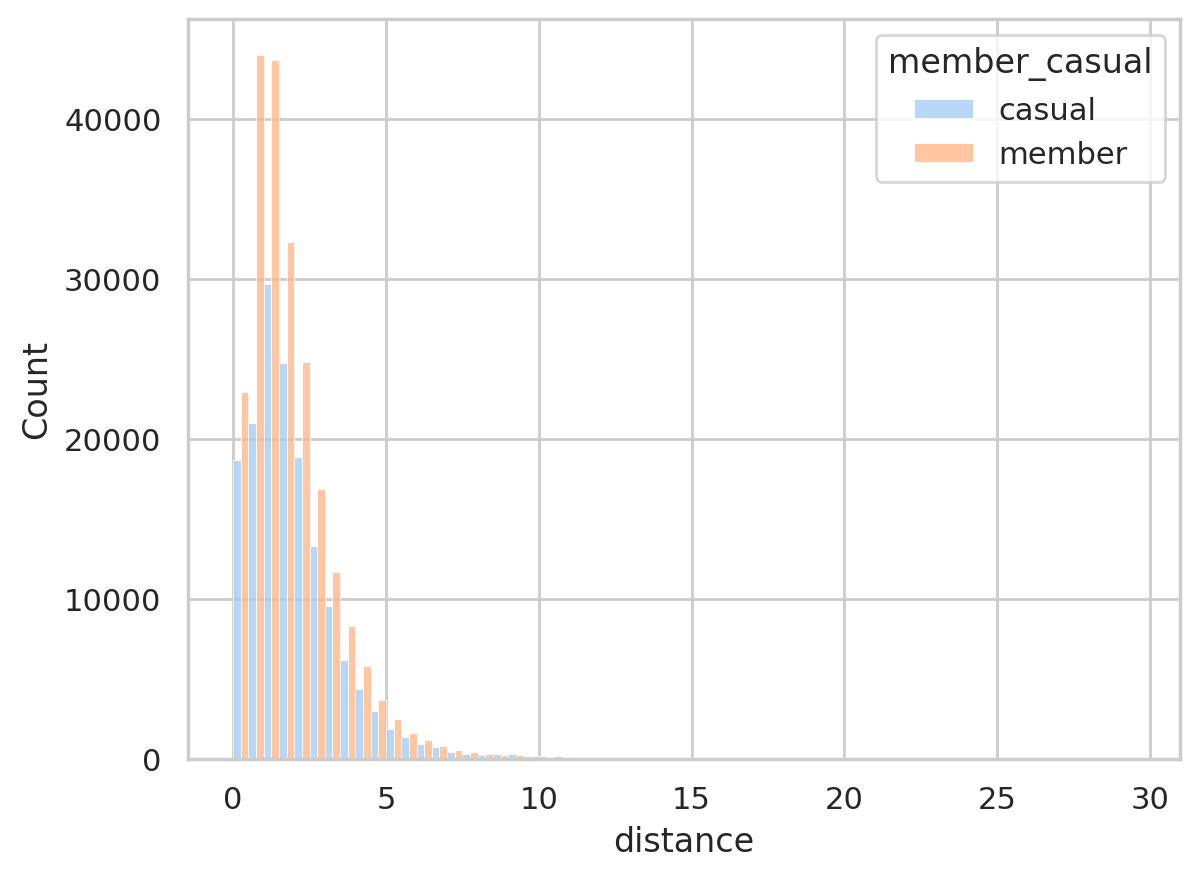

In [206]:
# plot net distance, excluding false starts, by member status
sns.histplot(data=df_2023_04_nfs, x='distance', binwidth=0.5, hue='member_casual', multiple="dodge")
# plt.ylim(0, 80000)
# plt.xlim(0, 30)

## plot journey elapsed time, excluding false starts, by member status

In [220]:
#TODO: having some problems with new elapsed column. troubleshooting steps: check dtype
df_2023_04_nfs.dtypes

ride_id                        object
rideable_type                category
started_at             datetime64[ns]
ended_at               datetime64[ns]
start_station_name             object
start_station_id              float64
end_station_name               object
end_station_id                float64
start_lat                     float64
start_lng                     float64
end_lat                       float64
end_lng                       float64
member_casual                category
distance                      float64
elapsed               timedelta64[ns]
dtype: object

TypeError: The DType <class 'numpy.dtype[float64]'> could not be promoted by <class 'numpy.dtype[timedelta64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float64]'>, <class 'numpy.dtype[timedelta64]'>)

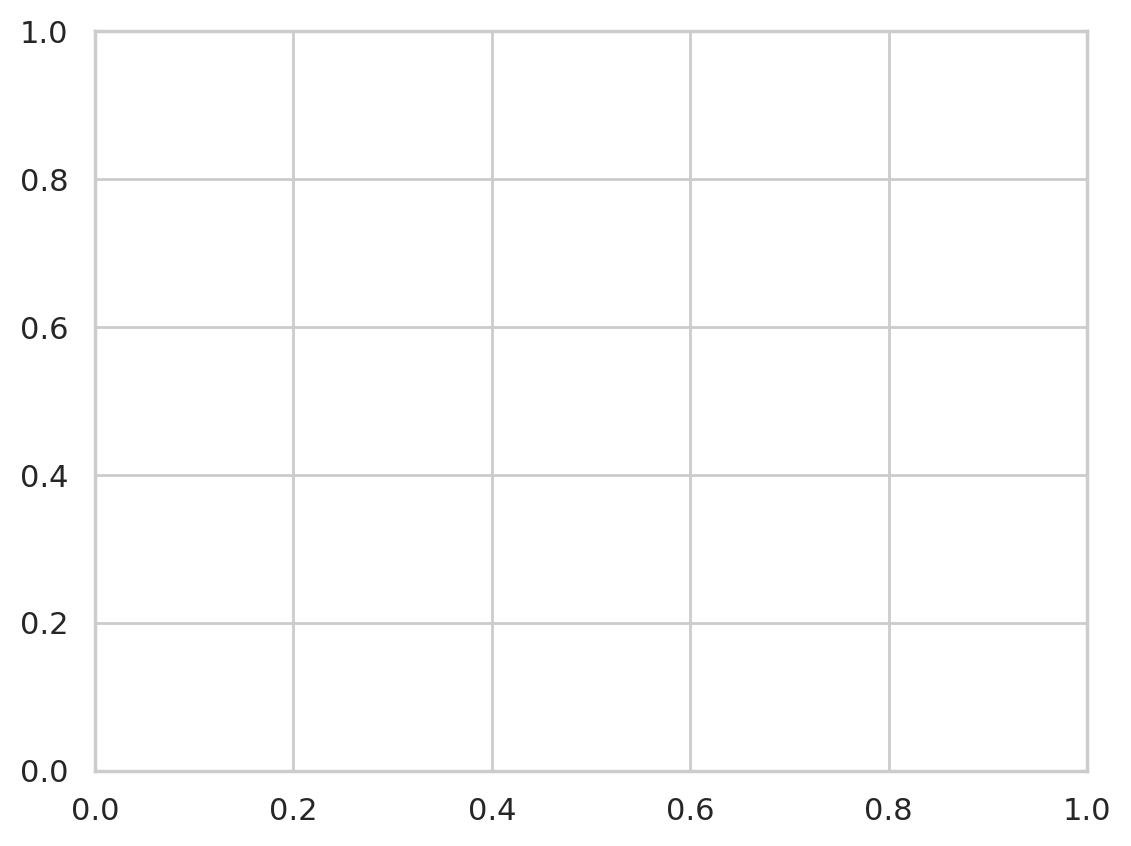

In [263]:
#df_2023_04_nfs['elapsed'].astype('timedelta64[s]').plot.hist() #did not work

#df_2023_04_nfs['elapsed'].dt.days.hist() #did not work

#https://stackoverflow.com/questions/62281476/attributeerror-timedeltaproperties-object-has-no-attribute-minute
#df_2023_04_nfs['elapsed'].dt.total_seconds().plot() # produced a hist but didn't have any negative values so is not correct 

#df_2023_04_nfs['elapsed'].view('int64').plot() #same (hist or plot)

#df_2023_04_nfs['elapsed'].astype('timedelta64[m]').plot() # the df shows the right data but the plot is the same so i think i just ahve to use sns to specify a better plot

#plt.scatter(df_2023_04_nfs.distance.values, df_2023_04_nfs.elapsed.values.astype('timedelta64[m]')) does not work


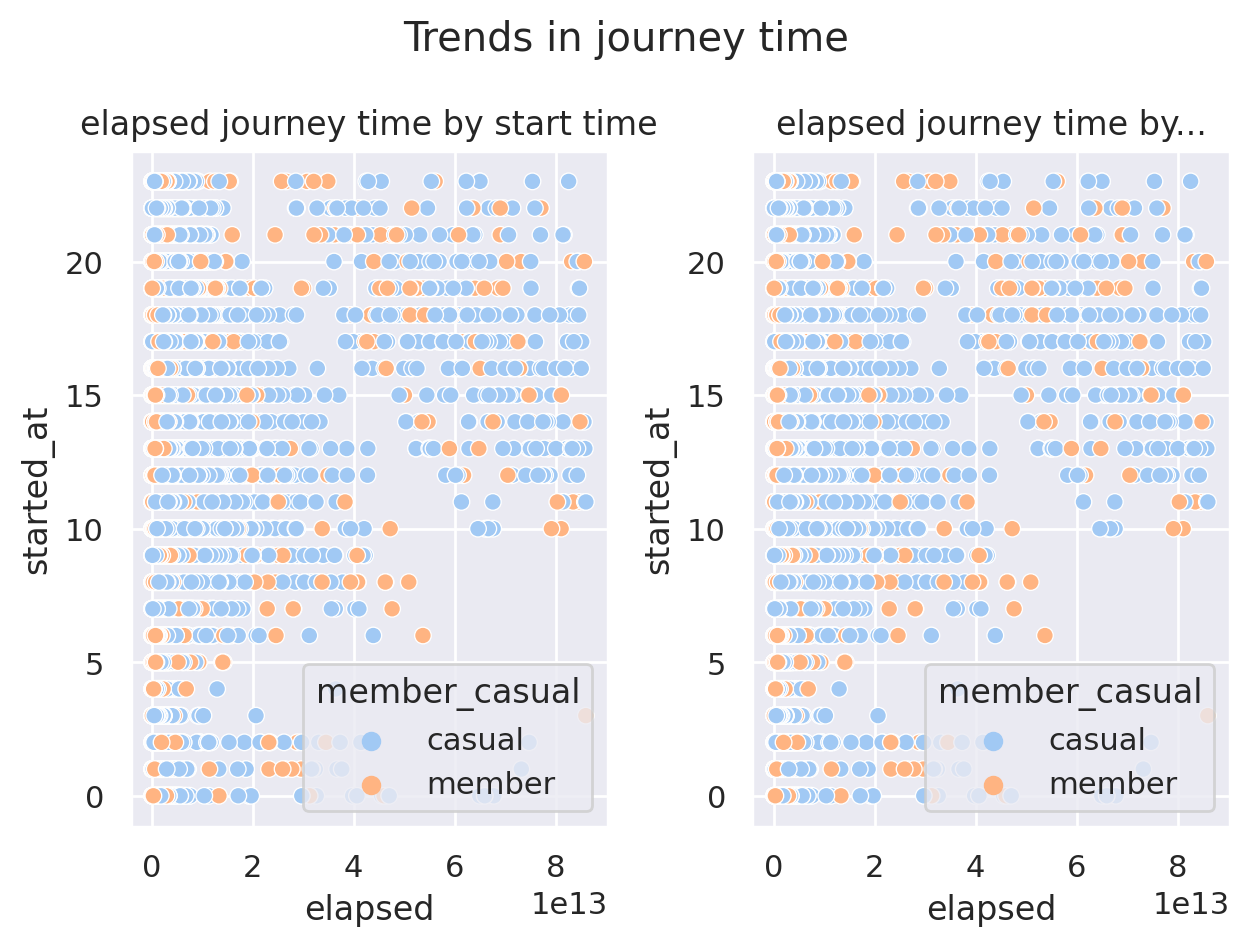

In [279]:
#testing with a filtered df: only durations between 00:00 and 23:59 hours
t_lower = np.timedelta64(1, 'm')
t_upper = np.timedelta64(1439, 'm')
df_elap_filt = df_2023_04_nfs[(df_2023_04_nfs['elapsed'] < t_upper) & (df_2023_04_nfs['elapsed'] > t_lower)]

fig, axes=plt.subplots(1,2)

sns.set_style('darkgrid')
sns.scatterplot(ax=axes[0], data=df_elap_filt, y=df_elap_filt.started_at.dt.hour, x=df_elap_filt.elapsed, hue='member_casual')
axes[0].set_title('elapsed journey time by start time')

sns.scatterplot(ax=axes[1], data=df_elap_filt, y=df_elap_filt.started_at.dt.hour, x=df_elap_filt.elapsed, hue='member_casual')
axes[1].set_title('elapsed journey time by...')

fig.suptitle('Trends in journey time')

plt.tight_layout()

<Axes: xlabel='started_at', ylabel='elapsed'>

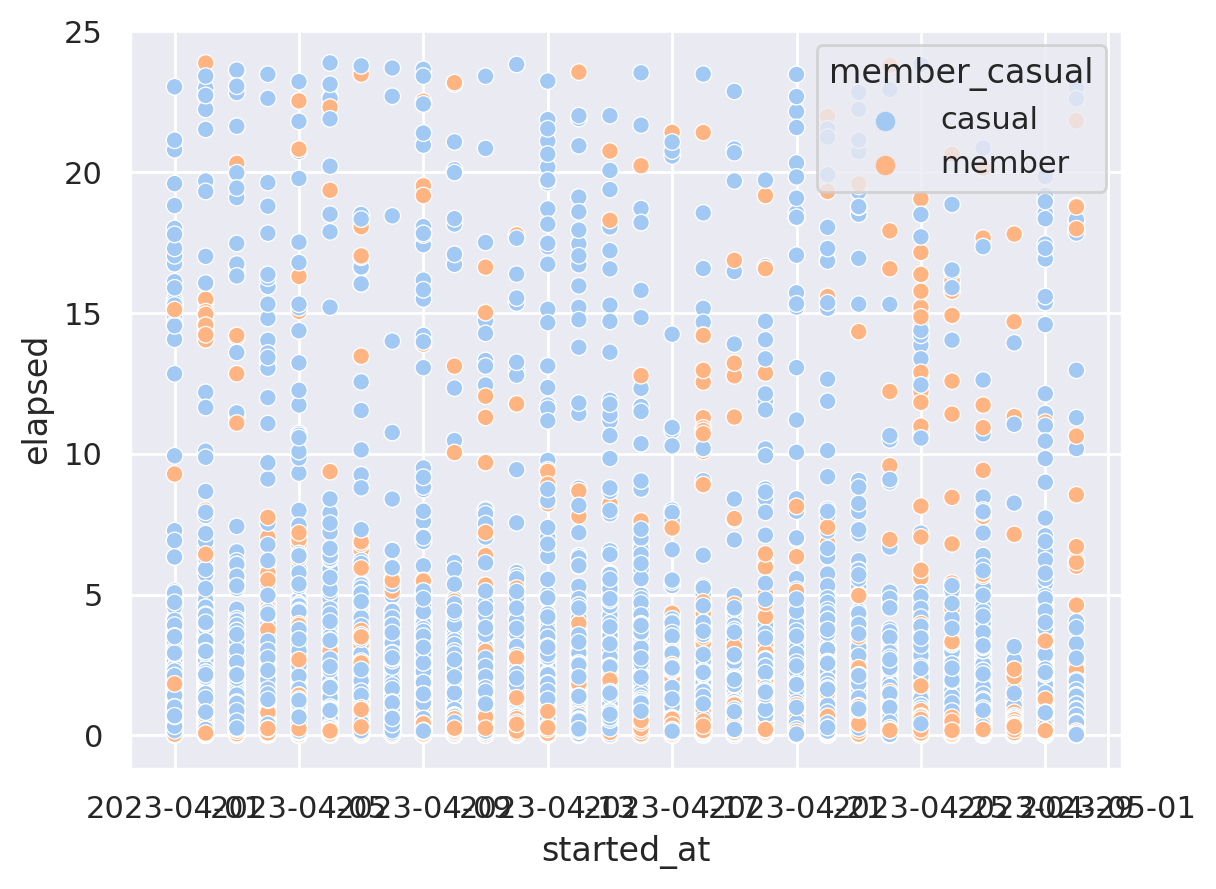

In [299]:
sns.scatterplot(data=df_elap_filt, x=df_elap_filt.started_at.dt.date, y=df_elap_filt.elapsed.dt.seconds/3600, hue='member_casual')

TypeError: The DType <class 'numpy.dtype[timedelta64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[timedelta64]'>, <class 'numpy.dtype[float64]'>)

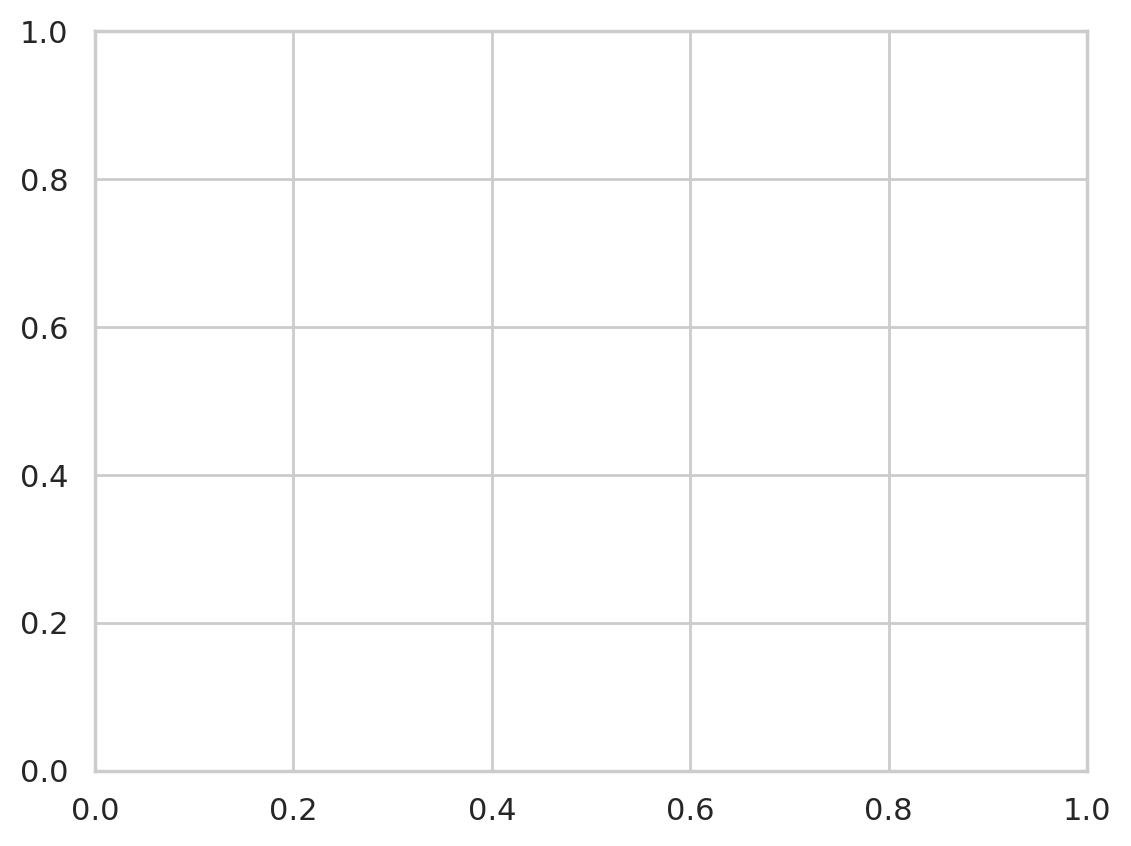

In [277]:
# plot journey elapsed time, excluding false starts, by member status
g_hour_elap = sns.scatterplot(data=df_2023_04_nfs, x='elapsed', y='distance', hue='member_casual')

MemoryError: Unable to allocate 12.8 PiB for an array with shape (1799739000000002,) and data type float64

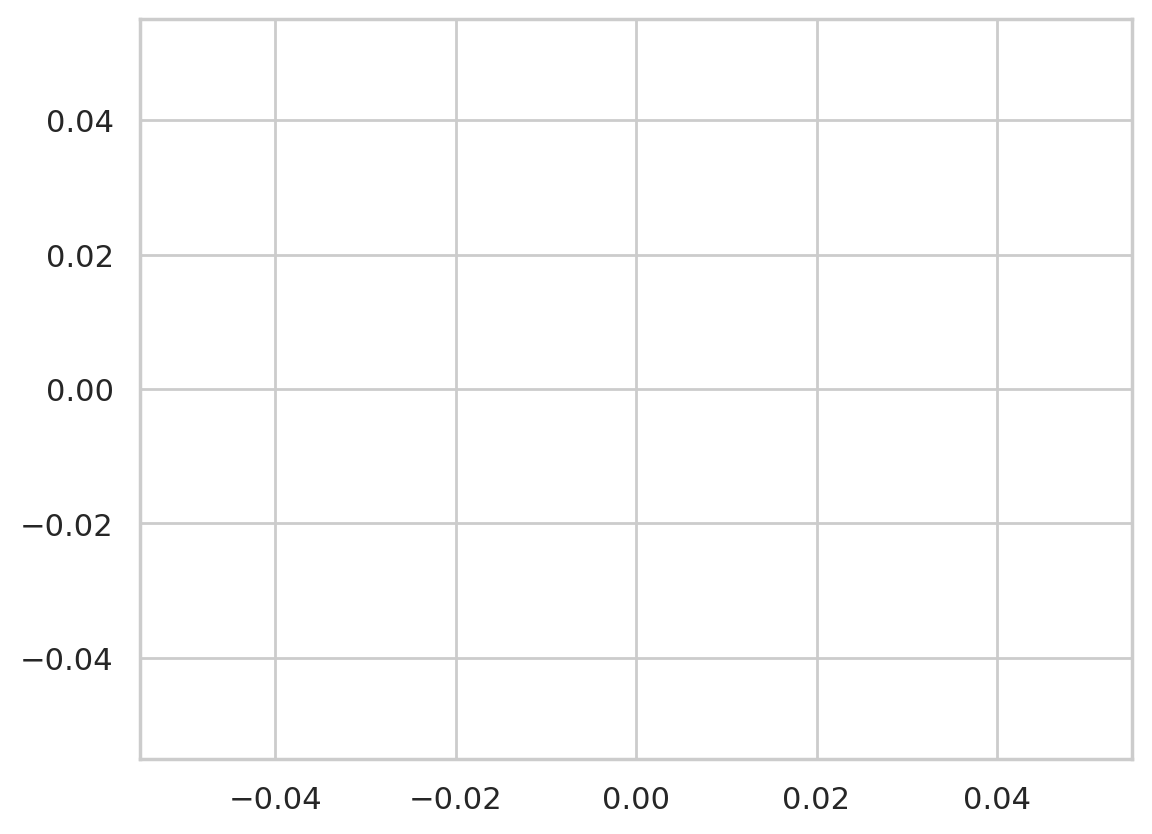

In [217]:
sns.histplot(data=df_2023_04_nfs.elapsed)


In [218]:
g_hour_elap_1 = sns.boxplot(data=df_2023_04_nfs, y=elapsed[], x='member_casual') ## make this reference a part fo the datetime object

TypeError: Neither the `x` nor `y` variable appears to be numeric.

- am I parsing my data wrong or are there some bikes which spent a very long time out of docks skewing the data? what is the maximum journey time?

In [178]:
df_2023_04_nfs.describe()

,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,distance,elapsed
count,355452.000000,353224.000000,379370.000000,379370.000000,378682.000000,378682.000000,378682.000000,379370.000000
mean,31369.741782,31370.755673,38.902501,-77.031938,38.901607,-77.031617,1.928360,1261.124999
std,280.603392,282.240053,0.026312,0.033710,0.026152,0.033582,1.525189,2971.195790
min,30200.000000,30200.000000,38.780000,-77.390000,38.710000,-77.390000,0.000000,0.000000
25%,31212.000000,31213.000000,38.890496,-77.044400,38.890000,-77.044400,0.914577,411.000000
50%,31278.000000,31278.000000,38.902400,-77.031606,38.901755,-77.030230,1.580637,712.000000
75%,31606.000000,31609.000000,38.912966,-77.013769,38.912630,-77.012808,2.552183,1279.000000
max,33200.000000,33200.000000,39.125842,-76.825535,39.125828,-76.825535,29.009908,86399.000000


In [179]:
#show overview of time elapsed
display("Max length:", df_2023_04_nfs.elapsed.max(), "Mean length:", df_2023_04_nfs.elapsed.mean(), "Median length:", df_2023_04_nfs.elapsed.median())

'Max length:'

86399

'Mean length:'

1261.1249993410127

'Median length:'

712.0

In [180]:
df_2023_04_nfs

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance,elapsed
0,7D89911108C4305F,classic_bike,2023-04-15 12:51:45,2023-04-15 12:57:14,16th & Harvard St NW,31135.0,Lamont & Mt Pleasant NW,31107.0,38.926102,-77.036650,38.931900,-77.038800,member,0.670575,329
1,FF47021098DE06BD,electric_bike,2023-04-11 18:21:35,2023-04-11 18:37:47,Rosedale Rec Center,31658.0,6th St & Indiana Ave NW,31264.0,38.897897,-76.979721,38.894573,-77.019940,member,3.497933,972
2,BB41905DB8DE1CC7,classic_bike,2023-04-16 18:09:23,2023-04-16 18:26:10,2nd St & Seaton Pl NE,31522.0,15th & W St NW,31125.0,38.914751,-77.003560,38.919018,-77.034449,member,2.712487,1007
3,0B1CB1A1E2380DD9,electric_bike,2023-04-29 17:13:36,2023-04-29 17:17:37,2nd St & Seaton Pl NE,31522.0,MBT & Bryant St NE,31531.0,38.914697,-77.003593,38.922404,-76.996023,member,1.077837,241
4,D321DE32CAFDDD51,classic_bike,2023-04-29 17:53:46,2023-04-29 18:02:10,23rd & E St NW,31260.0,15th & M St NW,31298.0,38.896104,-77.049882,38.905424,-77.034674,member,1.674044,504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389238,EAA293669D7032B0,electric_bike,2023-04-12 17:10:02,2023-04-12 17:33:47,Thomas Jefferson St NW & Water/K St NW,31293.0,13th & H St NE,31611.0,38.902996,-77.060003,38.900427,-76.988250,member,6.211805,1425
389239,E76129D0EB71B579,classic_bike,2023-04-05 17:25:35,2023-04-05 18:04:43,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613.0,13th & H St NE,31611.0,38.884095,-76.995234,38.900427,-76.988250,casual,1.912751,2348
389240,5A2E2DED1A83FCFE,classic_bike,2023-04-17 21:18:44,2023-04-17 21:27:38,Eastern Market Metro / Pennsylvania Ave & 8th ...,31613.0,13th & H St NE,31611.0,38.884095,-76.995234,38.900427,-76.988250,casual,1.912751,534
389241,AADF7A5217DC964E,classic_bike,2023-04-08 18:11:21,2023-04-08 18:47:46,Lincoln Memorial,31258.0,4th & E St SW,31244.0,38.888255,-77.049436,38.884120,-77.017445,casual,2.805129,2185


In [181]:
df_2023_04_nfs.count()

ride_id               379370
rideable_type         379370
started_at            379370
ended_at              379370
start_station_name    355452
start_station_id      355452
end_station_name      353224
end_station_id        353224
start_lat             379370
start_lng             379370
end_lat               378682
end_lng               378682
member_casual         379370
distance              378682
elapsed               379370
dtype: int64

<Axes: xlabel='rideable_type', ylabel='elapsed'>

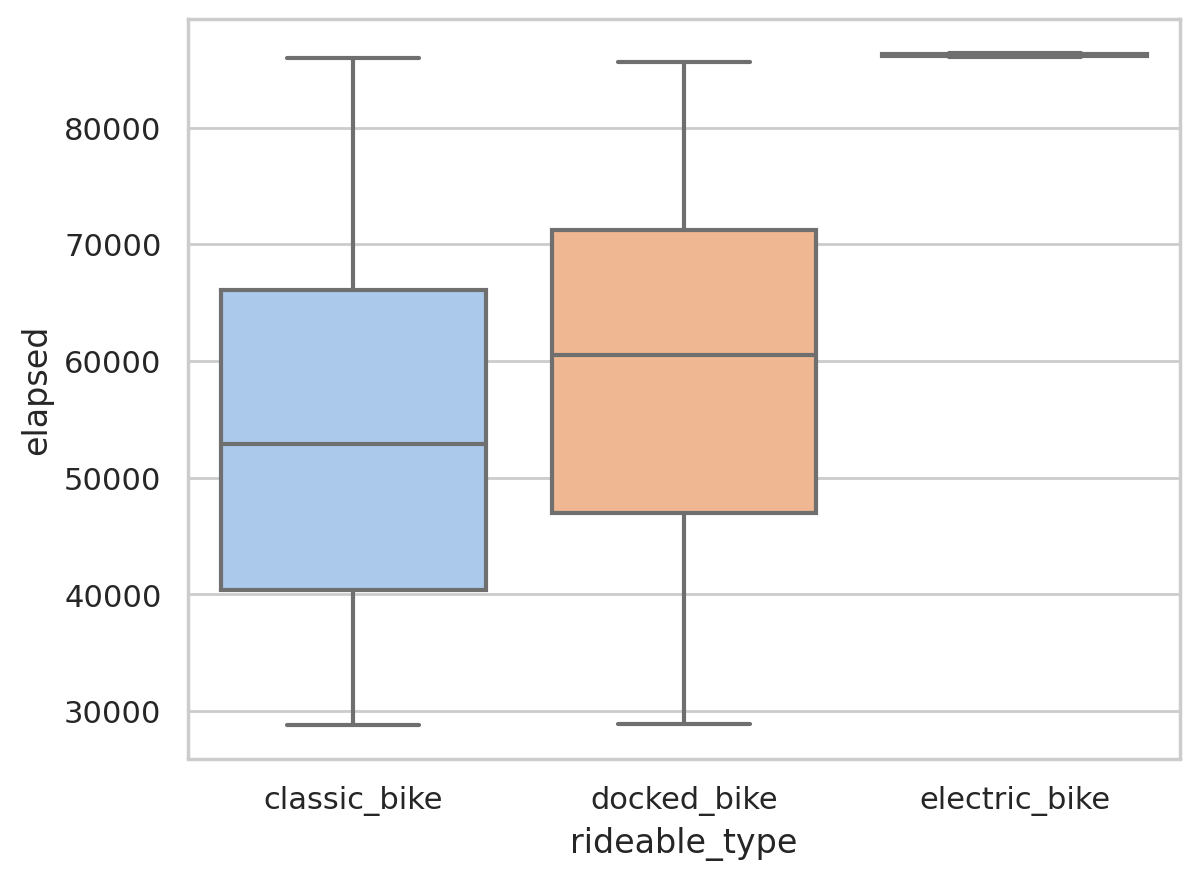

In [182]:
#show journeys over 8 hours
df_over_8h = df_2023_04_nfs[df_2023_04_nfs['elapsed'] > 28800]
sns.boxplot(data = df_over_8h, x = "rideable_type", y = "elapsed", )

"Your use of the Services is limited to a period of 24 consecutive hours" - https://assets.capitalbikeshare.com/rental-agreement.html

In [183]:
#show journeys over 23 hours (there are none over 24 - this is a mistake in parting time! fix! must have taken only the minutes part rather than converting?)
df_2023_04_nfs[df_2023_04_nfs['elapsed'] > 82800]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance,elapsed
628,30C84312F198C567,docked_bike,2023-04-26 13:00:59,2023-04-29 12:09:43,Pooks Hill Rd & Linden Ave,32057.0,Pooks Hill Rd & Linden Ave,32057.0,39.014716,-77.107143,39.014716,-77.107143,casual,0.000000,83324
1272,F90D7A98137277F4,docked_bike,2023-04-08 13:52:36,2023-04-09 13:34:48,Ohio Dr & West Basin Dr SW / MLK & FDR Memorials,31240.0,NaN,NaN,38.884120,-77.046570,NaN,NaN,casual,NaN,85332
2238,7763469AF9413038,electric_bike,2023-04-14 13:34:41,2023-04-14 13:33:08,NaN,NaN,23rd & E St NW,31260.0,38.900000,-77.050000,38.896104,-77.049882,member,0.433064,86307
3464,15E0EA56A0FFE919,classic_bike,2023-04-07 11:04:37,2023-04-08 10:33:50,Crystal City Metro / 18th St & S Bell St,31007.0,Long Bridge Aquatic Center,31950.0,38.857785,-77.051698,38.870561,-77.044095,member,1.564728,84553
11125,E55D603944B8FCD0,electric_bike,2023-04-01 13:10:57,2023-04-01 13:05:36,NaN,NaN,1st & D St SE,31643.0,38.880000,-77.010000,38.884916,-77.005965,member,0.648278,86079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367351,A5FEB0D90D4FFF67,classic_bike,2023-04-12 11:40:53,2023-04-13 11:30:37,8th & O St NW,31281.0,Convention Center / 7th & M St NW,31223.0,38.908640,-77.022770,38.905737,-77.022270,casual,0.325481,85784
379587,B7EDAB3A8838AD51,electric_bike,2023-04-21 16:23:59,2023-04-21 16:23:52,NaN,NaN,1st & M St NE,31603.0,38.910000,-77.010000,38.905697,-77.005483,member,0.617426,86393
379755,D74873D17179E534,electric_bike,2023-04-21 16:46:40,2023-04-21 16:43:44,NaN,NaN,1st & M St NE,31603.0,38.910000,-77.010000,38.905697,-77.005483,casual,0.617426,86224
379896,8AF796C9F1C394B4,electric_bike,2023-04-13 08:43:55,2023-04-13 08:43:01,NaN,NaN,13th & D St NE,31622.0,38.890000,-76.990000,38.894832,-76.987633,member,0.574661,86346


I've made an error with my data somewhere. things to check:
- did I convert all times properly?
- are all end times after start times?
- if not, why don't have negative time elapsed?

- did I convert all times properly?

- are all end times after start times?


- if not, why don't have negative time elapsed?

## Scatterplot of... TODO

In [184]:
#TODO: make a scatterplot?

# fig, axes=plt.subplots(1,2)

# sns.set_style('darkgrid')
# sns.scatterplot(ax=axes[0], data=df_hour, y=df_hour.cnt, x=df_hour.windspeed, hue='registered_proportion')
# axes[0].set_title('Windspeed')

# sns.scatterplot(ax=axes[1],data=df_hour, y=df_hour.cnt, x=df_hour.temp, hue='registered_proportion')
# axes[1].set_title('Temperature (Normalized)')

# fig.suptitle('Count of rides by windspeed and temperature')

# plt.tight_layout()

## Boxplot of day-wise Distribution

In [185]:
#TODO: sns.boxplot(data=df_2023_04, x='', y='')

# Trips per day per bicycle (TDB)
This is a metric proposed for the success of a bike sharing scheme bye Médard de Chardon et al. (2017)

# Multivariate analysis: heatmap

In [186]:
#TODO

# Time Series Analysis

# Time Series line graphs

In [187]:
# x = df_day['dteday']
# y = df_day['cnt']

# plt.plot(x, y)

# plt.title('Rides per day')
# plt.xlabel('Date')
# plt.ylabel('Rides')

Linear regression with time series

In [188]:
#TODO

In [189]:
import pandas as pd
multi_index = pd.MultiIndex.from_tuples([("r0", "rA"),
                                       ("r1", "rB")],
                                       names=['Courses','Fee'])
cols = pd.MultiIndex.from_tuples([("Gasoline", "Toyoto"), 
                                  ("Gasoline", "Ford"), 
                                  ("Electric", "Tesla"),
                                  ("Electric", "Nio")])

data=[[100,300, 900,400 ], [200,500, 300,600]]

df = pd.DataFrame(data, columns=cols,index=multi_index)
print(df)

            Gasoline      Electric     
              Toyoto Ford    Tesla  Nio
Courses Fee                            
r0      rA       100  300      900  400
r1      rB       200  500      300  600


In [190]:

# MultiIndex to Single Index
df2 = df.reset_index(level=[1])
print(df2)


        Fee Gasoline      Electric     
              Toyoto Ford    Tesla  Nio
Courses                                
r0       rA      100  300      900  400
r1       rB      200  500      300  600


In [191]:

# Convert Multi-index to Columns
df2=df.reset_index()
print(df2)


  Courses Fee Gasoline      Electric     
                Toyoto Ford    Tesla  Nio
0      r0  rA      100  300      900  400
1      r1  rB      200  500      300  600
